In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# functions

def rem_outliers(df, col):
    ''' Remove outliers which fall outside of 3 standard deviations above and below the mean of the data set
            Input
                (0) dataframe containing the data
                (1) column to remove outliers from
            Output
                rows of df which are classified as outliers in the specified column are directly removed
                print out stating count of outliers removed '''
    mean, cutoff = np.mean(df[col]), np.std(df[col]) * 3   # 3 stddev outside the mean
    lower, upper = mean - cutoff, mean + cutoff
    outliers = [x for x in df[col] if x < lower or x > upper]
    df.drop(df[(df[col] > upper) | (df[col] < lower)].index, inplace=True)
    return f'{len(outliers)} outliers removed'

# Models incorporating weather data

In [3]:
# import joined table
df = pd.read_csv('data/flights_for_weather_joined.csv')
# drop useless columns
df.drop(columns=['Unnamed: 0', 'origin_city_name', 'dest_city_name', 'dup'], inplace=True)
# split data
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask].copy()
df_test = df[~mask].copy()

In [4]:
# remove outliers for arr_delay
rem_outliers(df_train, 'arr_delay')

'87381 outliers removed'

In [5]:
# get mean delays per carrier
carrier_delays = df_train.groupby('mkt_unique_carrier').mean()['arr_delay'].sort_values()

In [6]:
carrier_delays.sort_values()

mkt_unique_carrier
DL   -3.788203
B6   -3.475944
VX   -3.349896
AS   -1.821548
NK   -1.802648
UA   -1.396647
HA   -0.911696
WN   -0.382472
F9   -0.306235
G4    0.765197
AA    1.181994
Name: arr_delay, dtype: float64

<BarContainer object of 11 artists>

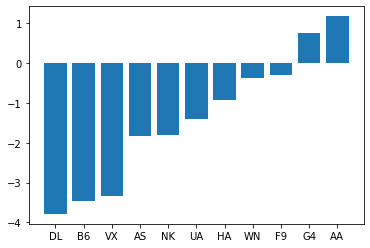

In [7]:
plt.bar(x=carrier_delays.index, height=carrier_delays.values)

There seems to be a significant difference in average delays per carrier, so that's worth factoring in.

In [8]:
# create rankings for carriers
rankings = {}
for carr in carrier_delays.index:
    if carrier_delays[carr] <= -2:
        rankings[carr] = 0
    elif carrier_delays[carr] > -2 and carrier_delays[carr] <= 0:
        rankings[carr] = 1
    elif carrier_delays[carr] > 0:
        rankings[carr] = 2
        
def rank_carrier(carr):
    return rankings[carr]

df_train['carrier_speed_rank'] = df_train['mkt_unique_carrier'].apply(rank_carrier)

Text(0.5, 1.0, 'Mean delay times by flight number')

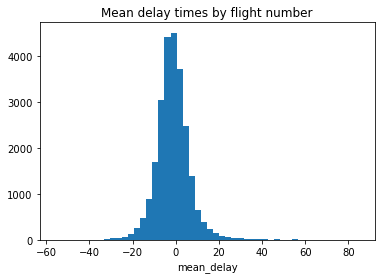

In [9]:
# check distribution of mean delay per flight number
flight_num_delay = df_train.groupby(['op_unique_carrier','op_carrier_fl_num']).mean().arr_delay.sort_values()

plt.hist(flight_num_delay, bins=50)
plt.xlabel("mean_delay")
plt.title("Mean delay times by flight number")

In [10]:
# bin by mean delay time
ranks = pd.qcut(flight_num_delay, 5, labels = [0,1,2,3,4])
ranks

op_unique_carrier  op_carrier_fl_num
OO                 4749                 0
UA                 1648                 0
DL                 2214                 0
F9                 1907                 0
B6                 1088                 0
                                       ..
ZW                 3156                 4
9E                 5540                 4
AS                 280                  4
WN                 1117                 4
AA                 2162                 4
Name: arr_delay, Length: 24926, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

In [11]:
df_train['flight_num_speed_rank'] = df_train.apply(lambda x: ranks.loc[x.op_unique_carrier, x.op_carrier_fl_num], axis=1)

In [12]:
# add month column
def month(datestring):
    date = datetime.strptime(datestring, "%Y-%m-%d")
    return date.month

df_train['month'] = df_train.fl_date.apply(month)

Text(0.5, 1.0, 'mean delays per month')

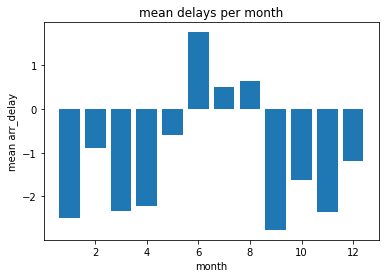

In [13]:
# check correlation of month with delay
month_delays = df_train.groupby('month').mean().arr_delay

plt.bar(x=month_delays.index, height=month_delays.values)
plt.xlabel("month")
plt.ylabel("mean arr_delay")
plt.title("mean delays per month")

In [14]:
# bin months by mean delays
bins = pd.qcut(month_delays, 3, labels=[0,1,2])
df_train['month_rank'] = df_train.month.apply(lambda x: bins.loc[x])

In [15]:
# add columns for hour of departure and arrival 
def hour(t):
    s = str(t)
    if len(s) < 3:
        return 0
    elif len(s) == 3:
        return int(s[0])
    elif len(s) == 4:
        if int(s[:2]) == 24:
            return 0
        else:
            return int(s[:2])

df_train['dep_hour'] = df_train.crs_dep_time.apply(hour)
df_train['arr_hour'] = df_train.crs_arr_time.apply(hour)

<BarContainer object of 24 artists>

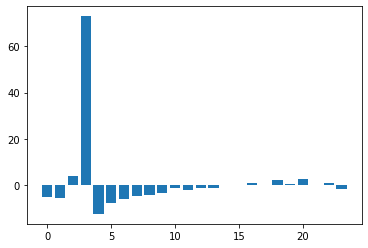

In [16]:
# relate hour of departure to arr_delay
dep_hour_delay = df_train.groupby('dep_hour').mean().arr_delay
plt.bar(x=dep_hour_delay.index, height=dep_hour_delay.values)

In [17]:
# 0300 is an outlier because there's only one case of it
ranks = pd.qcut(dep_hour_delay, 3, labels=[0,1,2])

df_train['dep_hour_rank'] = df_train.dep_hour.apply(lambda x: ranks.loc[x])

<BarContainer object of 24 artists>

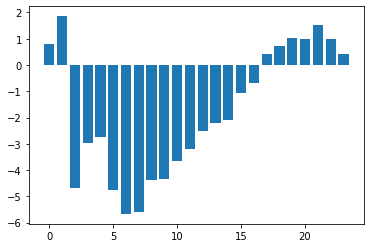

In [18]:
# same for arrival hour
arr_hour_delay = df_train.groupby('arr_hour').mean().arr_delay
plt.bar(x=arr_hour_delay.index, height=arr_hour_delay.values)

In [19]:
# bin values
ranks = pd.qcut(arr_hour_delay, 3, labels=[0,1,2])

df_train['arr_hour_rank'] = df_train.arr_hour.apply(lambda x: ranks.loc[x])

In [20]:
# save progress
# df_train.to_csv('data/weather_features_save.csv')

#### Weather columns

In [21]:
df_train.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,dest_airport_id,dest,...,windgust,cloudcover,carrier_speed_rank,flight_num_speed_rank,month,month_rank,dep_hour,arr_hour,dep_hour_rank,arr_hour_rank
0,2018-01-01,DL,3494,9E,N302PQ,3494,10397,ATL,15412,TYS,...,40.7,74.3,0,1,1,0,19,20,2,2
1,2018-01-01,DL,3500,9E,N316PQ,3500,10397,ATL,10431,AVL,...,40.7,74.3,0,0,1,0,22,22,2,2
2,2018-01-01,DL,3513,9E,N316PQ,3513,10397,ATL,11995,GSO,...,40.7,74.3,0,3,1,0,15,16,1,1
3,2018-01-01,B6,1,B6,N954JB,1,12478,JFK,11697,FLL,...,55.4,24.9,0,2,1,0,10,14,1,1
5,2018-01-01,B6,18,B6,N236JB,18,12478,JFK,10721,BOS,...,55.4,24.9,0,1,1,0,13,15,1,1


In [22]:
print(len(df_train))
df_train.dropna(inplace=True)
print(len(df_train))

3226948
3090686


(array([2.701048e+06, 1.539810e+05, 8.373600e+04, 5.511400e+04,
        3.839800e+04, 1.927700e+04, 1.429400e+04, 5.167000e+03,
        7.962000e+03, 1.936000e+03, 1.578000e+03, 1.139000e+03,
        1.312000e+03, 1.665000e+03, 2.656000e+03, 0.000000e+00,
        3.670000e+02, 0.000000e+00, 6.500000e+02, 4.060000e+02]),
 array([  0.   ,   5.941,  11.882,  17.823,  23.764,  29.705,  35.646,
         41.587,  47.528,  53.469,  59.41 ,  65.351,  71.292,  77.233,
         83.174,  89.115,  95.056, 100.997, 106.938, 112.879, 118.82 ]),
 <a list of 20 Patch objects>)

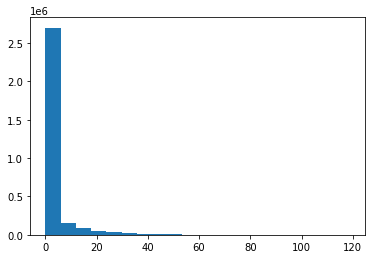

In [23]:
# check distribution of weather columns
plt.hist(df_train.precip, bins=20)

In [24]:
# how well does nonzero precipitation correlate with delays?
df_precip = df_train[df_train.precip != 0]
precip = pd.cut(df_precip.precip, 3, labels = ['light','moderate','heavy'])
df_precip.groupby(precip).mean().arr_delay
# plt.scatter(x=precip.precip, y=precip.arr_delay)

precip
light        2.081741
moderate     8.306971
heavy       11.443942
Name: arr_delay, dtype: float64

In [25]:
df_precip.precip.sort_values()

2929191      0.01
1644386      0.01
1644387      0.01
1644412      0.01
3818602      0.01
            ...  
3030486    118.82
3030483    118.82
3030481    118.82
3027966    118.82
3027944    118.82
Name: precip, Length: 1089270, dtype: float64

In [26]:
precip_bins = precip = pd.cut(df_precip.precip, 3, retbins=True)
precip_bins[1]

array([-1.08810000e-01,  3.96133333e+01,  7.92166667e+01,  1.18820000e+02])

In [27]:
precip = pd.cut(df_precip.precip, 3, labels=["light", "moderate", "heavy"])
df_train['precip_cat'] = precip.astype(str)
df_train.precip_cat.fillna(value="None", inplace=True)

Text(0, 0.5, 'Mean arr_delay')

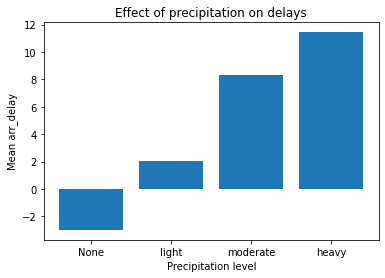

In [28]:
precip_means = df_train.groupby('precip_cat').mean().arr_delay.sort_values()
plt.bar(x=precip_means.index, height=precip_means.values)
plt.title("Effect of precipitation on delays")
plt.xlabel("Precipitation level")
plt.ylabel("Mean arr_delay")

#### Snow

(array([3.031492e+06, 2.009100e+04, 2.002800e+04, 3.760000e+03,
        7.016000e+03, 2.002000e+03, 1.465000e+03, 7.370000e+02,
        2.410000e+03, 2.800000e+02, 2.100000e+02, 0.000000e+00,
        4.300000e+02, 0.000000e+00, 6.510000e+02, 0.000000e+00,
        1.400000e+01, 0.000000e+00, 0.000000e+00, 1.000000e+02]),
 array([ 0.   ,  0.737,  1.474,  2.211,  2.948,  3.685,  4.422,  5.159,
         5.896,  6.633,  7.37 ,  8.107,  8.844,  9.581, 10.318, 11.055,
        11.792, 12.529, 13.266, 14.003, 14.74 ]),
 <a list of 20 Patch objects>)

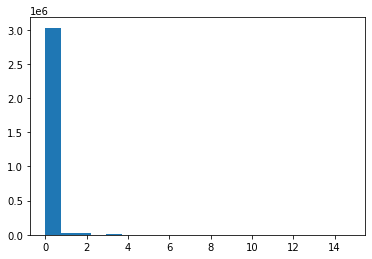

In [29]:
plt.hist(df_train.snow, bins=20)

In [30]:
df_snow = df_train[df_train.snow != 0]
snowcats = pd.qcut(df_snow.snow, 3)
df_snow.groupby(snowcats).mean().arr_delay

snow
(0.049, 1.04]    4.998591
(1.04, 1.88]     4.878224
(1.88, 14.74]    9.536541
Name: arr_delay, dtype: float64

In [31]:
# add this into df_train
df_train['snow_cat'] = snowcats.astype(str)
df_train.snow_cat.fillna(value="None", inplace=True)

In [32]:
df_train.snow_cat.value_counts()

None             3016042
(0.049, 1.04]      29805
(1.88, 14.74]      24794
(1.04, 1.88]       20045
Name: snow_cat, dtype: int64

Text(0, 0.5, 'Mean arr_delay')

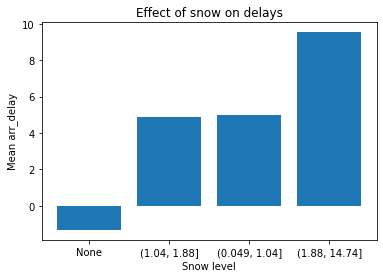

In [33]:
snow_means = df_train.groupby('snow_cat').mean().arr_delay.sort_values()
plt.bar(x=snow_means.index, height=snow_means.values)
plt.title("Effect of snow on delays")
plt.xlabel("Snow level")
plt.ylabel("Mean arr_delay")

#### Windgust

(array([1.037545e+06, 0.000000e+00, 8.430000e+02, 0.000000e+00,
        3.129810e+05, 5.926650e+05, 3.343200e+05, 3.051920e+05,
        2.215940e+05, 1.096100e+05, 7.373300e+04, 3.752800e+04,
        3.830400e+04, 1.231200e+04, 6.611000e+03, 4.891000e+03,
        7.100000e+02, 1.206000e+03, 2.680000e+02, 3.730000e+02]),
 array([  0.   ,   6.285,  12.57 ,  18.855,  25.14 ,  31.425,  37.71 ,
         43.995,  50.28 ,  56.565,  62.85 ,  69.135,  75.42 ,  81.705,
         87.99 ,  94.275, 100.56 , 106.845, 113.13 , 119.415, 125.7  ]),
 <a list of 20 Patch objects>)

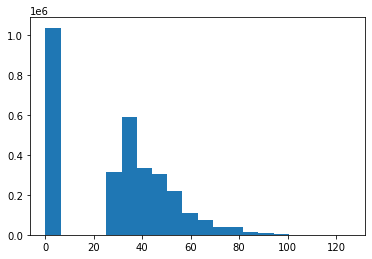

In [34]:
plt.hist(df_train.windgust, bins=20)

In [35]:
# bin only on nonzero values
df_wind = df_train[df_train.windgust != 0]
bins = pd.qcut(df_wind.windgust, 3)
df_wind.groupby(bins).mean().arr_delay.sort_values()


windgust
(14.799000000000001, 35.3]   -1.593131
(35.3, 46.5]                 -0.421189
(46.5, 125.7]                 0.682517
Name: arr_delay, dtype: float64

In [36]:
df_train['windgust_cat'] = bins.astype(str)
df_train.windgust_cat.fillna(value="None", inplace=True)

### cloudcover

(array([ 80062., 152643., 239978., 297709., 382898., 418667., 423770.,
        350550., 334572., 409837.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

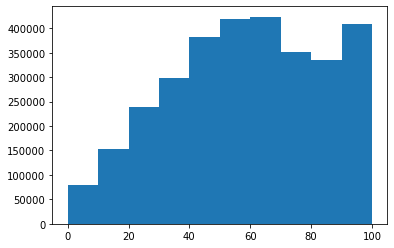

In [37]:
plt.hist(df_train.cloudcover)

In [38]:
bins = pd.qcut(df_train.cloudcover, 3)
df_train.groupby(bins).mean().arr_delay.sort_values()

cloudcover
(-0.001, 47.3]   -2.604859
(47.3, 71.8]     -1.538212
(71.8, 100.0]     0.734273
Name: arr_delay, dtype: float64

In [39]:
df_train['cloud_cat'] = bins

In [40]:
# df_train.to_csv('data/weather_feature_save.csv')

In [41]:
df_train.columns

Index(['fl_date', 'mkt_unique_carrier', 'mkt_carrier_fl_num',
       'op_unique_carrier', 'tail_num', 'op_carrier_fl_num',
       'origin_airport_id', 'origin', 'dest_airport_id', 'dest',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'precip', 'snow', 'windgust', 'cloudcover',
       'carrier_speed_rank', 'flight_num_speed_rank', 'month', 'month_rank',
       'dep_hour', 'arr_hour', 'dep_hour_rank', 'arr_hour_rank', 'precip_cat',
       'snow_cat', 'windgust_cat', 'cloud_cat'],
      dtype='object')

In [ ]:
df_

In [42]:
feats = df_train[['fl_date', 'mkt_unique_carrier', 'mkt_carrier_fl_num',
       'op_unique_carrier', 'tail_num', 'op_carrier_fl_num',
       'origin_airport_id', 'origin', 'dest_airport_id', 'dest',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'precip', 'snow', 'windgust', 'cloudcover',
       'carrier_speed_rank', 'flight_num_speed_rank', 'month', 'month_rank',
       'dep_hour', 'arr_hour', 'dep_hour_rank', 'arr_hour_rank', 'precip_cat',
       'snow_cat', 'windgust_cat', 'cloud_cat']]
feats

,carrier_speed_rank,flight_num_speed_rank,month_rank,dep_hour_rank,arr_hour_rank,precip_cat,snow_cat,windgust_cat,cloud_cat,arr_delay
0,0,1,0,2,2,None,None,"(35.3, 46.5]","(71.8, 100.0]",-2.0
1,0,0,0,2,2,None,None,"(35.3, 46.5]","(71.8, 100.0]",-6.0
2,0,3,0,1,1,None,None,"(35.3, 46.5]","(71.8, 100.0]",-12.0
3,0,2,0,1,1,None,None,"(46.5, 125.7]","(-0.001, 47.3]",74.0
5,0,1,0,1,1,None,None,"(46.5, 125.7]","(-0.001, 47.3]",-2.0
...,...,...,...,...,...,...,...,...,...,...
4141425,2,4,2,1,1,None,None,"(14.799000000000001, 35.3]","(-0.001, 47.3]",-5.0
4141426,2,2,2,1,1,None,None,"(14.799000000000001, 35.3]","(-0.001, 47.3]",-19.0
4141428,2,4,2,2,2,light,None,"(46.5, 125.7]","(47.3, 71.8]",82.0
4141429,2,4,2,2,2,light,None,"(46.5, 125.7]","(47.3, 71.8]",22.0


In [266]:
feats = pd.get_dummies(data=feats)

# Model 1: LinReg, sample of data, weather only

In [274]:
# create sample of data
feats_sample = feats.sample(n=10000, random_state=58)

In [277]:
X = feats_sample[['precip_cat_None',
       'precip_cat_heavy', 'precip_cat_light', 'precip_cat_moderate',
       'snow_cat_None', 'snow_cat_heavy', 'snow_cat_light',
       'windgust_cat_None', 'windgust_cat_light', 'windgust_cat_moderate',
       'windgust_cat_strong', 'cloud_cat_0', 'cloud_cat_1', 'cloud_cat_2']].to_numpy()
y = feats_sample.arr_delay

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [279]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [294]:
filename = 'models/lr.sav'
pickle.dump(lr, open(filename, 'wb'))

In [281]:
lr.score(X_test, y_test)

0.026503953784403622

# Model 2: Whole set, weather only

In [283]:
X = feats[['precip_cat_None',
       'precip_cat_heavy', 'precip_cat_light', 'precip_cat_moderate',
       'snow_cat_None', 'snow_cat_heavy', 'snow_cat_light',
       'windgust_cat_None', 'windgust_cat_light', 'windgust_cat_moderate',
       'windgust_cat_strong', 'cloud_cat_0', 'cloud_cat_1', 'cloud_cat_2']].to_numpy()
y = feats.arr_delay

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [284]:
lr2 = LinearRegression()
lr2.fit(X_train, y_train)

LinearRegression()

In [295]:
filename = 'models/lr2.sav'
pickle.dump(lr2, open(filename, 'wb'))

In [285]:
lr2.score(X_test, y_test)

0.01747998952818297

# Model 3: Linear Regression, whole set, all features

In [287]:
X = feats.drop(columns='arr_delay').to_numpy()
y = feats.arr_delay.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [288]:
lr3 = LinearRegression()
lr3.fit(X_train, y_train)

LinearRegression()

In [296]:
filename = 'models/lr3.sav'
pickle.dump(lr3, open(filename, 'wb'))

In [290]:
lr3.score(X_test, y_test)

0.07250786250338603